# Evaluating HydroShoot memory capcity

"""Configure data sources"""

EXPERIMENT_ROOT = 'F:/thesis-cyborg-plants/results/fixed_predawn_7days_jun_jul_aug'

In [6]:
"""Import general dependencies"""

%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

In [7]:
"""Import own source and configure hot reloading"""

%load_ext autoreload
%reload_ext autoreload
%autoreload 2  # will autoreload all packages imported with %aimport

sys.path.insert(1, os.path.join(sys.path[0], '..'))  # for importing local packages from src


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
"""Loading dataset"""
from src.model.hydroshoot_experiment import load_runs, HydroShootExperiment

assert(os.path.isdir(EXPERIMENT_ROOT))
runs = load_runs(EXPERIMENT_ROOT)
print(len(runs))
print(runs[0])
print('Targets:', runs[0].get_targets())
print('Variables:', runs[0].get_state_variables())

84
HydroShootExperiment(n_steps=168, state_size=360)
Targets: ('input_Tac', 'input_u', 'input_hs', 'input_Rg', 'output_Rg', 'output_An', 'output_E', 'output_Tleaf')
Variables: ('Ci', 'gb', 'Ei', 'FluxC', 'Tlc', 'An', 'Flux', 'psi_head', 'u', 'E', 'Eabs', 'gs', 'par_photo.dHd')


## Evaluating inherent memory

The HydroShoot model shows little to no temporal correlation between the state variables across different leaves. This may indicate that the model may be lacking in the memory capacity property of a recurrent reservoir and that the different nodes are very strongly coupled.

### Visualizing state time series

In [9]:
np.random.seed(42)
sample_run = runs[np.random.randint(len(runs))]
plot_variables = ['An', 'Ei', 'Tlc', 'Flux', 'Eabs', 'gs', 'E',  'psi_head', 'FluxC']

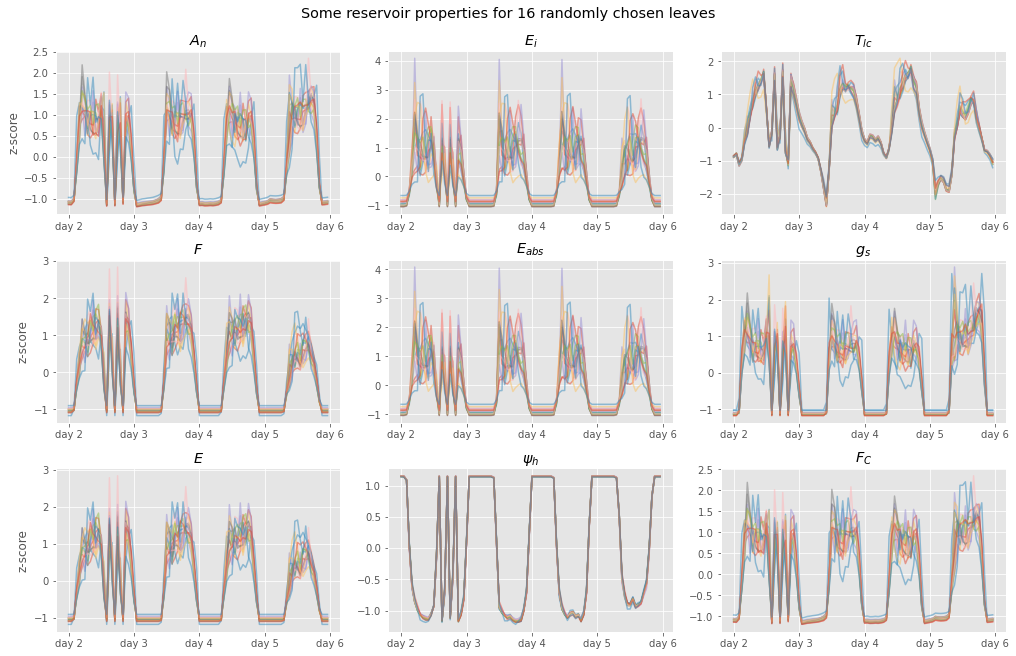

In [10]:
from util import VARIABLE_NAMES
from scipy.stats import zscore

def plot_properties_for_vertices(run, variables, state_size, ncols=4, alpha=0.6, window=None):
    cols = min(len(variables), ncols)
    rows = int(np.ceil(len(variables) / cols))

    state_data = run.states._states
    vertex_ids = list(state_data[variables[0]].keys())
    state_ids = np.random.choice(vertex_ids, state_size, replace=False)

    if window is None:
        start, end = 0, run.n_steps()
    else:
        start, end = window
    
    with plt.style.context('ggplot'):
        fig, axs = plt.subplots(rows, cols, figsize=(14, 3 * rows), squeeze=False, constrained_layout=True)
        
        for i, var in enumerate(variables):
            row = i // cols;
            col = i % cols;
            vertices = state_data[var]

            for vid in state_ids:
                series = vertices[vid][start:end]
                series = zscore(series)

                axs[row][col].plot(series, alpha=alpha)
                axs[row][col].set_title(VARIABLE_NAMES[var])
                axs[row][col].set_xticks(np.arange(0, end - start + 1, 24))
                axs[row][col].set_xticklabels([f'day {i}' for i in range(start // 24, (end // 24) + 1)])
                if col == 0:
                    axs[row][col].set_ylabel('z-score')

        fig.suptitle(f'Some reservoir properties for {len(state_ids)} randomly chosen leaves', size='x-large')
        plt.show()


state_ids = np.random.choice(sample_run.state_size(), size=16, replace=False)
        
plot_properties_for_vertices(sample_run, plot_variables, 16, alpha=0.5, ncols=3, window=(48, 144))

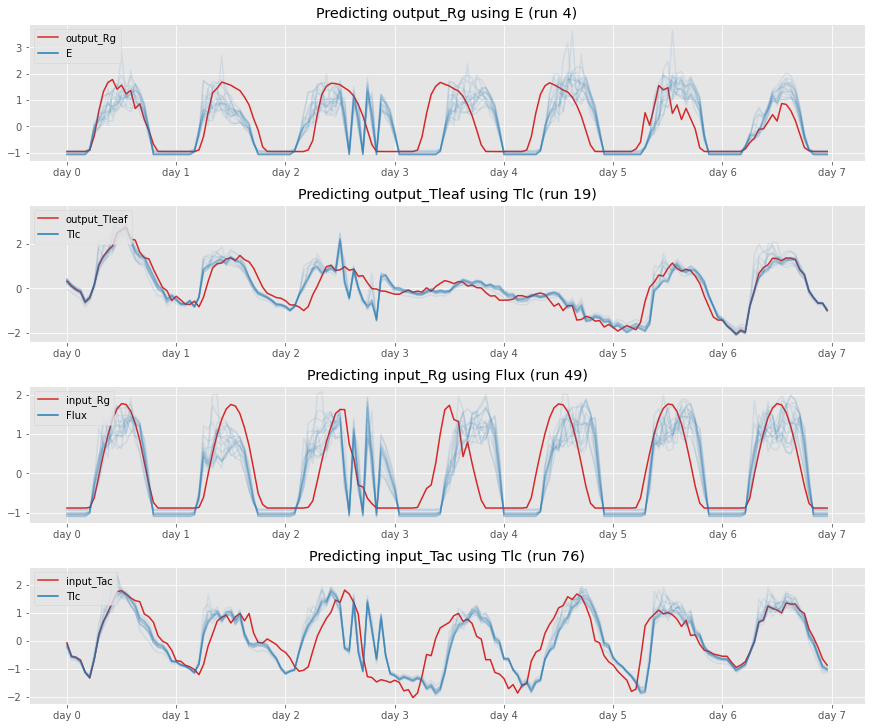

In [11]:
"""Visualize fit with some example targets"""


model_targets = [('E', 'output_Rg'), ('Tlc', 'output_Tleaf'), ('Flux', 'input_Rg'), ('Tlc', 'input_Tac')]
run_ids = [4, 19, 49, 76]

np.random.seed(42)


with plt.style.context('ggplot'):
  fig, ax = plt.subplots(4, 1, figsize=(12, 10), constrained_layout=True)

  for i, (var, target) in enumerate(model_targets):
    
    run_id = run_ids[i]  # np.random.randint(len(runs))
    sample_run = runs[run_id]
    target_data = zscore(sample_run.get_target(target))
    state_data = zscore(sample_run.states[var])
    state_data = state_data[:, np.random.choice(state_data.shape[1], 16, replace=False)]

    ax[i].set_xticks(range(0, sample_run.n_steps() + 1, 24))
    ax[i].set_xticklabels([f'day {i}' for i in range((sample_run.n_steps() // 24) + 1)])
    ax[i].plot(target_data, color='tab:red', label=target)
    ax[i].plot(state_data, color='tab:blue', alpha=0.1)
    ax[i].plot([], color='tab:blue', label=var)
    ax[i].set_title(f'Predicting {target} using {var} (run {run_id})')
    ax[i].legend(loc='upper left')

  plt.show()


Takeaways:

- While the relation between leaves is nonlinear, they all seem to be based on a single baseline, and 
- Their amplitude modulation seems to be tied to the time of day in the same fashion for each node.

### Define baseline score

In [12]:
"""Define readout parameters."""

from src.learning.preprocessing import generate_mask

STATE_SIZE = 64
SAMPLES_PER_RUN = 1
N_CV_GROUPS = 4
DAYLIGHT_MASK = generate_mask(5, 21)

In [13]:
"""Define cross-validation folds."""

from sklearn.model_selection import LeaveOneGroupOut

folds = LeaveOneGroupOut()

In [14]:
"""Define model pipeline and parameter search grid."""

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e6), 25)
}]

In [15]:
from src.constants import HYDROSHOOT_STATE_VARIABLES

targets = sorted(runs[0].get_targets())
variables = sorted(HYDROSHOOT_STATE_VARIABLES)

print(targets)
print(variables)

['input_Rg', 'input_Tac', 'input_hs', 'input_u', 'output_An', 'output_E', 'output_Rg', 'output_Tleaf']
['An', 'E', 'Eabs', 'Ei', 'Flux', 'FluxC', 'Tlc', 'gb', 'gs', 'psi_head', 'u']


In [16]:
from tqdm import tqdm
from src.learning.training import evaluate_for_runs


model_targets = [(target, var) for target in targets for var in variables]
baseline_scores = []  # insert lists of model scores per target, var pairing


with tqdm(total = len(model_targets)) as pbar:
  for target, var in model_targets:
      result = evaluate_for_runs(readout, var, target, runs, N_CV_GROUPS, folds, search_grid, day_range=(1, 7),
                             state_size=STATE_SIZE, samples_per_run=SAMPLES_PER_RUN, mask=DAYLIGHT_MASK)
      baseline_scores.append(result)
      pbar.update(1)

100%|██████████| 88/88 [01:23<00:00,  1.05it/s]


from collections import defaultdict

from util import VARIABLE_NAMES 

score_dict = defaultdict(lambda : {})
for target, var, model, base_score, tuned_score in baseline_scores:
  tuned_cv_mean, tuned_cv_std = tuned_score[1]
  score_dict[target][var] = tuned_cv_mean


baseline_nmse_matrix = np.empty((len(targets), len(variables)))
for row, (target, variable_dict) in enumerate(score_dict.items()):
  for col, (variable, score)  in enumerate(variable_dict.items()):
    baseline_nmse_matrix[row, col] = -score


fig, ax = plt.subplots(figsize=(9, 9))

img = ax.imshow(baseline_nmse_matrix, cmap='plasma_r', vmin=0, vmax=1)

# add value labels
for (col, row), value in np.ndenumerate(baseline_nmse_matrix):
  if not np.isnan(value):
    ax.text(row, col, f'{value:.2f}', ha='center', va='center')

ax.set_xticks(np.arange(len(variables)))    
ax.set_xticklabels([VARIABLE_NAMES[v] for v in variables])
ax.set_yticks(np.arange(len(targets)))    
ax.set_yticklabels(targets)

ax.set_title(f'Baseline scores of prediction task')
plt.colorbar(img, fraction=0.0335, pad=0.04)
plt.show()


## Injecting memory with delay lines

If the reservoir lacks the required memory capacity for performing a task, we can artificially introduce memory by duplicating the state and adding it as input signal on a delay.

The specific delay step size or the amount of delay lines to introduce can be determined as hyperparameters of the model.

In [17]:
from src.learning.preprocessing import preprocess_data, reshape_data

X, y = preprocess_data(runs, 'Tlc', 'output_Tleaf', state_size=8, warmup_steps=48)
X_train, y_train = reshape_data(X, y)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)

(84, 1, 5, 24, 8) (84, 1, 5, 24)
(10080, 8) (10080,)


In [18]:
from typing import Sequence, Tuple

def add_delay_line(X: np.array, y: np.array, delays: Sequence[int]) -> Tuple[np.array, np.array]:
  """Adds a delayed copy of X to the returend X and returns
  the truncated version of both X and y. The arrays will be
  truncated in steps of 24 to ensure the data can be reshaped
  into a (day, steps) array."""
  for d in delays:
    if d > 24:
      raise ValueError('Only delays <= 24 steps are allowed.')

  n_runs, n_state_samples, n_days, n_steps, n_variables = X.shape

  if n_steps != 24:
    raise ValueError('Delay line should be applied before masking.')

  X = X.reshape(n_runs, n_state_samples, n_days * n_steps, n_variables)
  X_d = np.empty((n_runs, n_state_samples, n_days * n_steps, n_variables * (1 + len(delays))))
  y_d = y.reshape(n_runs, n_state_samples, n_days * n_steps)

  # Original state variables
  X_d[:, :, :, :n_variables] = X

  # Delayed state variables
  for i, delay in enumerate(delays):
    start, end = (i + 1) * n_variables, (i + 2) * n_variables
    X_d[:, :, delay:, start:end] = X[:, :, :-delay, :]
  assert(not np.allclose(X_d[:, :, :, n_variables:], 0))

  # Truncate the empty delayed steps
  X_d = X_d[:, :, 24:]
  y_d = y_d[:, :, 24:]

  # Reshape to original dimensions
  X_d = X_d.reshape((n_runs, n_state_samples, -1, n_steps, (1 + len(delays)) * n_variables))
  y_d = y_d.reshape((n_runs, n_state_samples, -1, n_steps))

  return X_d, y_d


X_d, y_d = add_delay_line(X, y, [1, 2, 4])
print(f'X: {X.shape} -> {X_d.shape}')
print(f'y: {y.shape} -> {y_d.shape}')
  

X: (84, 1, 5, 24, 8) -> (84, 1, 4, 24, 32)
y: (84, 1, 5, 24) -> (84, 1, 4, 24)


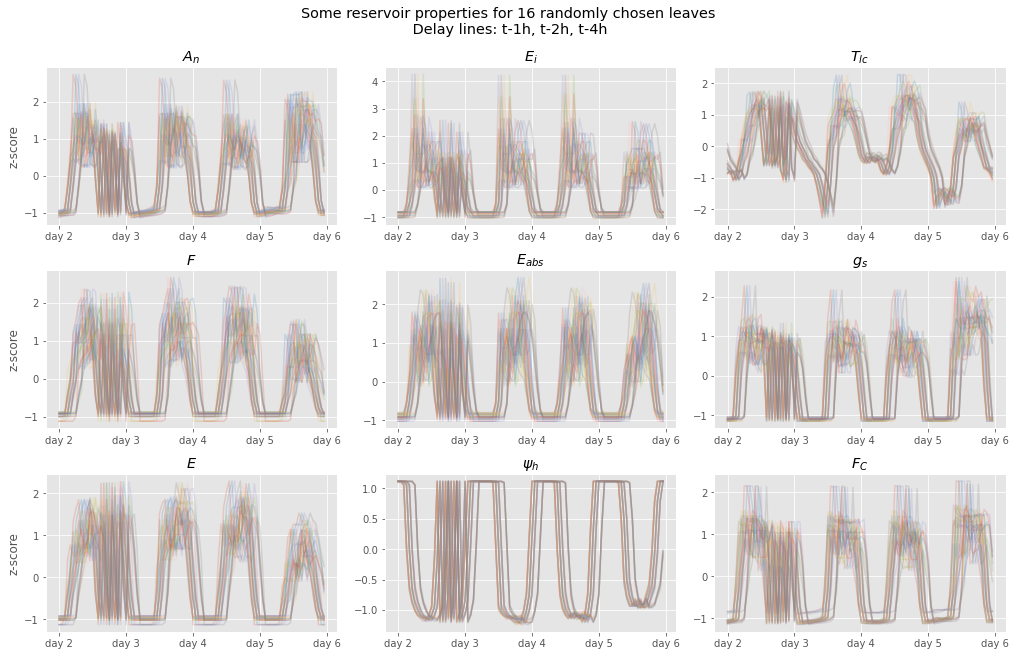

In [19]:
np.random.seed(42)
sample_run = runs[np.random.randint(len(runs))]
plot_variables = ['An', 'Ei', 'Tlc', 'Flux', 'Eabs', 'gs', 'E',  'psi_head', 'FluxC']


DELAYS= [1, 2, 4]

with plt.style.context('ggplot'):
        fig, axs = plt.subplots(3, 3, figsize=(14, 9), squeeze=False, constrained_layout=True)
        
        for i, var in enumerate(plot_variables):
            row = i // 3;
            col = i % 3;

            X, y = preprocess_data([sample_run], var, 'output_Tleaf', state_size=8, warmup_steps=0)
            X_d, y_d = add_delay_line(X, y, DELAYS)
            X_train, y_train = reshape_data(X_d, y_d)

            X_train = zscore(X_train, axis=0)

            # for vid in state_ids:
            # series = vertices[vid][start:end]
            # series = zscore(series)

            start, end = 24, 120

            axs[row][col].plot(X_train[start:end], alpha=0.2)
            axs[row][col].set_title(VARIABLE_NAMES[var])
            axs[row][col].set_xticks(np.arange(0, end - start + 1, 24))
            axs[row][col].set_xticklabels([f'day {i + 1}' for i in range(start // 24, (end // 24) + 1)])
            if col == 0:
                axs[row][col].set_ylabel('z-score')

        delays = ', '.join([f't-{d}h' for d in DELAYS])

        fig.suptitle(f'Some reservoir properties for {len(state_ids)} randomly chosen leaves\n Delay lines: {delays}', size='x-large')
        plt.show()

### Define score as function of delay lines

In [20]:
"""Define readout parameters."""

from src.learning.preprocessing import generate_mask

STATE_SIZE = 64
SAMPLES_PER_RUN = 1
N_CV_GROUPS = 4
DAYLIGHT_MASK = generate_mask(5, 21)

In [21]:
"""Define cross-validation folds."""

from sklearn.model_selection import LeaveOneGroupOut

folds = LeaveOneGroupOut()

In [22]:
"""Define model pipeline and parameter search grid."""

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e6), 25)
}]

In [23]:
from src.constants import HYDROSHOOT_STATE_VARIABLES

targets = sorted(runs[0].get_targets())
variables = sorted(HYDROSHOOT_STATE_VARIABLES)

print(targets)
print(variables)

['input_Rg', 'input_Tac', 'input_hs', 'input_u', 'output_An', 'output_E', 'output_Rg', 'output_Tleaf']
['An', 'E', 'Eabs', 'Ei', 'Flux', 'FluxC', 'Tlc', 'gb', 'gs', 'psi_head', 'u']


In [24]:
from src.learning.preprocessing import preprocess_data, reshape_data
from src.learning.training import get_cv_score, perform_gridsearch
from src.learning.grouping import group_by_day

from typing import Sequence

def evaluate_for_runs(model, var, target, runs, n_groups, folds, param_grid, 
                      verbose=False, day_range=None, delays=None, mask=None, **kwargs):
    """Trains the readout model for the given target and state variable, using 
    data from the passed runs, using n_group cross-validation.

    use day_range kwarg to only fit the model on a subset of the days in the model.
    day_range can be an int (first day of simulation) or tuple (start and end)

    NOTE: If delay lines are added, the first day is already truncated. This function
    will take into account that when delay is not None, the max. start day will be used.

    Unnamed kwargs are passed to the preprocess_data function.

    Returns a list of tuples: (target, var, fitted_model, untuned_scores, tuned_scores)"""

    X, y = preprocess_data(runs, var, target, **kwargs)

    if isinstance(delays, Sequence):
      X, y = add_delay_line(X, y, delays)
      if verbose:
        print('Added delays')

    if day_range is not None:
      if isinstance(day_range, int):
        start, end = day_range, X.shape[2]
      elif isinstance(day_range, Sequence):
        assert(len(day_range) == 2)
        start, end = day_range

      if delays is not None:
        # We know that delays are at most 23 steps, which is one day of truncation
        start -= 1
        end -= 1

      X = X[:, :, start:end]
      y = y[:, :, start:end]

    if mask is not None:
      # We apply the mask here instead of in preprocessing_data because of truncation
      X = X[:, :, :, mask]
      y = y[:, :, :, mask]

    X_train, y_train = reshape_data(X, y)
    groups = group_by_day(X, n_groups=n_groups)

    base_score = get_cv_score(model, X_train, y_train,
                              groups, folds, verbose=verbose)
    tuned_model, tuned_score = perform_gridsearch(
        model, X_train, y_train, groups, folds, param_grid, verbose=verbose)

    return (target, var, tuned_model, base_score, tuned_score)

#### Training

In [25]:
DELAYS = [1, 2, 4]


model_targets = [(target, var) for target in targets for var in variables]
delay_scores = []  # insert lists of model scores per target, var pairing


with tqdm(total = len(model_targets)) as pbar:
  for target, var in model_targets:
      result = evaluate_for_runs(readout, var, target, runs, N_CV_GROUPS, folds, search_grid, delays=DELAYS,
                                 day_range=(1, 7), state_size=STATE_SIZE, samples_per_run=SAMPLES_PER_RUN, mask=DAYLIGHT_MASK)
      delay_scores.append(result)
      pbar.update(1)

100%|██████████| 88/88 [02:40<00:00,  1.83s/it]


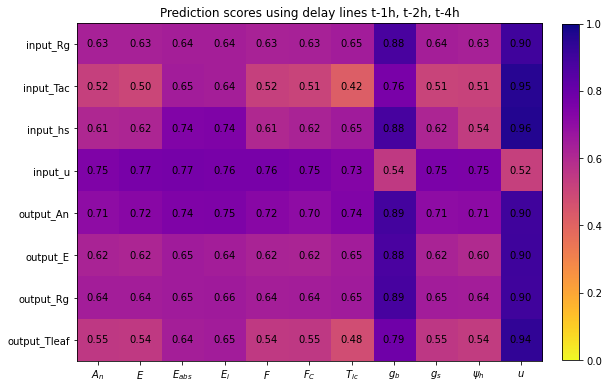

In [26]:
from collections import defaultdict

from util import VARIABLE_NAMES 

delay_score_dict = defaultdict(lambda : {})
for target, var, model, base_score, tuned_score in delay_scores:
  tuned_cv_mean, tuned_cv_std = tuned_score[1]
  delay_score_dict[target][var] = tuned_cv_mean


delay_nmse_matrix = np.empty((len(targets), len(variables)))
for row, (target, variable_dict) in enumerate(delay_score_dict.items()):
  for col, (variable, score)  in enumerate(variable_dict.items()):
    delay_nmse_matrix[row, col] = -score


fig, ax = plt.subplots(figsize=(9, 9))

img = ax.imshow(delay_nmse_matrix, cmap='plasma_r', vmin=0, vmax=1)

# add value labels
for (col, row), value in np.ndenumerate(delay_nmse_matrix):
  if not np.isnan(value):
    ax.text(row, col, f'{value:.2f}', ha='center', va='center')

ax.set_xticks(np.arange(len(variables)))    
ax.set_xticklabels([VARIABLE_NAMES[v] for v in variables])
ax.set_yticks(np.arange(len(targets)))    
ax.set_yticklabels(targets)


delay_str = ', '.join([f't-{d}h' for d in DELAYS])

ax.set_title(f'Prediction scores using delay lines {delay_str}')
plt.colorbar(img, fraction=0.0335, pad=0.04)
plt.show()


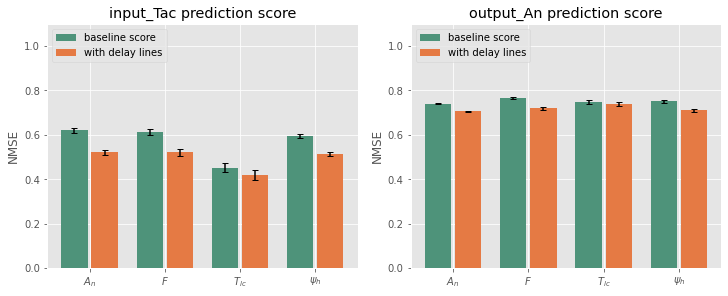

In [43]:
from util import VARIABLE_NAMES


def autolabel(ax, rects):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{:.2f}'.format(height),
                # xy=(rect.get_x() + rect.get_width() / 2, height),
                xy=(rect.get_x() + rect.get_width() / 2, 0),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plot_vars = ['An', 'Flux', 'Tlc', 'psi_head']
plot_targets = ['input_Tac', 'output_An']

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 2, figsize=(10, 4), squeeze=False, constrained_layout=True)

  pos = np.arange(len(plot_vars))
  ax_rects = []

  # for i, target in enumerate(targets):
  for i, target in enumerate(plot_targets):
    row = i // 2
    col = i % 2
    ax[row, col].set_ylim((0, 1.1))

    delay_mean = np.array([score_tuned[1][0] for (name_target, name_var, _, score_untuned, score_tuned) in delay_scores if name_target == target and name_var in plot_vars])
    delay_std = np.array([score_tuned[1][1] for (name_target, name_var, _, score_untuned, score_tuned) in delay_scores if name_target == target and name_var in plot_vars])
    delay_conf = 1.96 * delay_std / np.sqrt(N_CV_GROUPS)

    baseline_mean = np.array([score_tuned[1][0] for (name_target, name_var, _, score_untuned, score_tuned) in baseline_scores if name_target == target and name_var in plot_vars])
    baseline_std = np.array([score_tuned[1][1] for (name_target, name_var, _, score_untuned, score_tuned) in baseline_scores if name_target == target and name_var in plot_vars])
    baseline_conf = 1.96 * delay_std / np.sqrt(N_CV_GROUPS)

    # color = 'tab:red' if target.startswith('input') else 'tab:green'
    rects = ax[row, col].bar(pos - 0.2, -baseline_mean, 0.35, yerr=baseline_conf, color='#4E937A', capsize=3, label='baseline score')
    rects = ax[row, col].bar(pos + 0.2, -delay_mean, 0.35, yerr=delay_conf, color='#E57A44', capsize=3, label='with delay lines')
    # ax_rects.append((ax[row, col], rects))

    ax[row, col].set_title(f'{target} prediction score')
    ax[row, col].set_xticks(pos)
    variable_names = [name_var for (name_target, name_var, _, score_untuned, score_tuned) in delay_scores if name_target == target and name_var in plot_vars]
    variable_names = [VARIABLE_NAMES[v] for v in variable_names]
    ax[row, col].set_xticklabels(variable_names)
    ax[row, col].set_ylabel('NMSE')
    ax[row, col].legend(loc='upper left')

  # for ax, rects in ax_rects:
  #   autolabel(ax, rects)
  

  n_runs, n_state_samples, n_days, n_steps, n_variables = X.shape
  # fig.suptitle(f'Cross-validated scores for tuned readout function'
  #              f'\n\n{n_runs} runs spanning from 2012-06-01 to 2012-08-31'
  #              f'\n{n_days} days per run (excluding warmup)'
  #              f'\n\nReadout: Ridge regression with tuned hyperparameter λ'
  #              f'\nCross-validated in {N_CV_GROUPS} groups of alternating days (leave-one-out strategy)'
  #              f'\nreservoir_size={n_variables} \ndaylight_mask=5am-9pm \nwarmup_steps={WARMUP_STEPS}'
  #             )
  plt.show()